In [56]:
# If you're using Google Colab, you can run this cell to upgrade the required dependencies
#!pip install matplotlib==3.4.3
#!pip install --upgrade statsmodels

# Module 7. Time series analysis

## Introduction

Many decision-making applications depend on a forecast of some quantity.  
Unfortunately, forecasting is a very difficult task, both in the short and in the long run. Forecasts are usually based on historical data. Analysts look for patterns or relationships in the historical data and then make forecasts. There are two problems with this approach.  
The first is that it is not always easy to detect historical patterns or relationships. In particular, it is often difficult to separate the noise, or random behaviour, from the underlying patterns. Some forecasts may even exaggerate it, assigning importance to patterns that are in fact random variations and unlikely to recur.  
The second problem is that there are no guarantees that patterns from the past will continue in the future. A new war may break out somewhere in the world, the bottom may fall out of the stock market, ...


**Extrapolation Models**  
Extrapolation models are quantitative models that use historical data of a time series variable to predict future values of the variable. The idea is that historical movements of a variable, such as company sales or Belgian exports to Germany, can be used to predict future values of the variable.  
Many extrapolation models are available, including moving averages and exponential smoothing. These extrapolation models look for patterns in the historical series and then
extrapolate these patterns into the future. Some try to track upwards or downwards long-term
trends and then project them. Some try to follow seasonal patterns (such as an increase in sales in November and December, a decrease in other months) and then project them.


**Components of Time Series Data**  
There are four important
components of a time series. These components are called the trend component, the seasonal
component, the cyclic component, and the random (or noise) component.

If the observations increase or decrease regularly through time, we say that the time series has a **trend**.

Many time series have a **seasonal component**. For example, a company that sells swimming pool equipment sales increase each spring and then remain
relatively high in the summer, and then fall until next spring, after which the
annual pattern repeats itself. An important aspect of the seasonal component is that it tends to
be predictable from one year to the next. The same seasonal pattern tends to repeat itself every year.


A **cyclic pattern** exists when data exhibit rises and falls that are not of fixed period. For example, during a recession housing sales generally go down, unemployment goes up, stock prices go down, and so on. But when the recession is over, all of these variables tend to move in the opposite direction.
If the fluctuations are not of fixed period then they are cyclic; if the period is unchanging and associated with some aspect of the calendar, then the pattern is seasonal.

The **random component (or noise)** is the unpredictable component that gives most time series graphs their irregular, zigzag appearance.
Usually, a time series can be determined only to a certain extent by its trend, seasonal, and cyclic components. Then other factors determine the rest. These other factors can be inherent randomness, unpredictable "shocks" to the system, the unpredictable behavior of human beings who interact with the system, and possibly others.

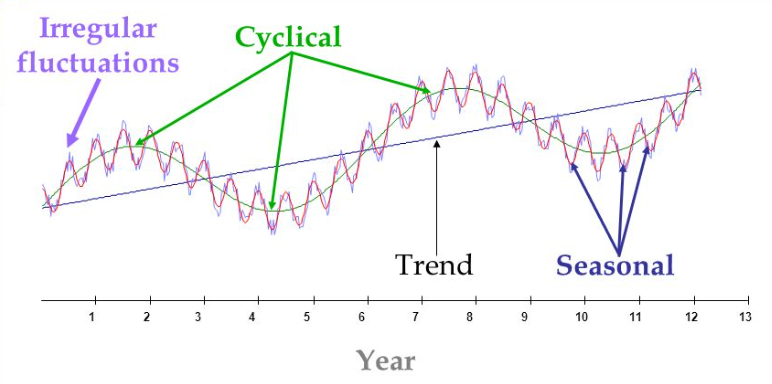

  The figure below shows the decomposition of the pregnancy number time series (top panel) into thee components: trend, seasonality, and residuals. [Published in Annual review of public health 2006
On time series analysis of public health and biomedical data.
S. Zeger, R. Irizarry, R. Peng]


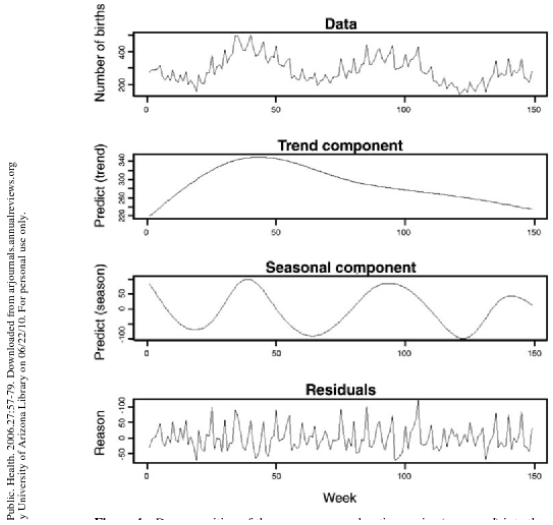

In [3]:
# Package imports
import numpy as np                                  # "Scientific computing"
import pandas as pd                                 # Dataframe

import scipy.stats as stats                         # Statistical tests
from sklearn.linear_model import LinearRegression   # Linear regression model

import matplotlib.pyplot as plt                     # Basic visualisation
from statsmodels.graphics.mosaicplot import mosaic  # Mosaic plot
import seaborn as sns                               # Advanced dataviz

In [4]:
# Read the data from CSV, parse dates and set the index
wounded_data = pd.read_csv(
    'https://raw.githubusercontent.com/HoGentTIN/dsai-en-labs/main/data/number_of_heavily_wounded_car_accidents_VL.txt',
    delimiter = "\t",
    parse_dates=['date']).set_index(['date'])

# Add frequency info to the index
wounded_data.index = pd.DatetimeIndex(wounded_data.index, freq='MS')

wounded_data.head()

,number_of_heavily_wounded
date,
2013-01-01,285
2013-02-01,276
2013-03-01,332
2013-04-01,381
2013-05-01,393


Remark that when creating the index for the data frame, we set the frequency to `MS`, i.e. Month Start, since each observation is taken at the first day of the month. A list of valid frequencies ([offset aliases](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)) can be found [in the Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).

In Python, a time series can also be represented by an instance of the Pandas [`Series`](https://pandas.pydata.org/docs/reference/api/pandas.Series.html) class with an index of type DatetimeIndex.

As always, a graph of the time series is a good place to start analyzing the data. It indicates whether a linear trend is likely to provide a good fit. Generally, the graph should rise or fall at approximately a constant rate through time, without too much random (unpredictable) variation.

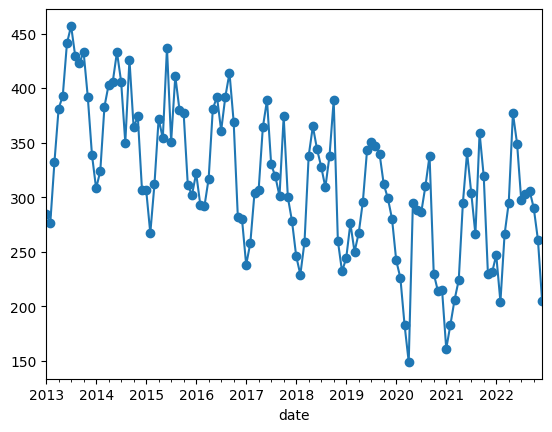

In [4]:
wounded_ts = pd.Series(
    data=np.array(wounded_data['number_of_heavily_wounded']),
    index=wounded_data.index
)
wounded_ts.plot(marker='o');

Columns in a `DataFrame` can also be processed as time series with the time/date as index.

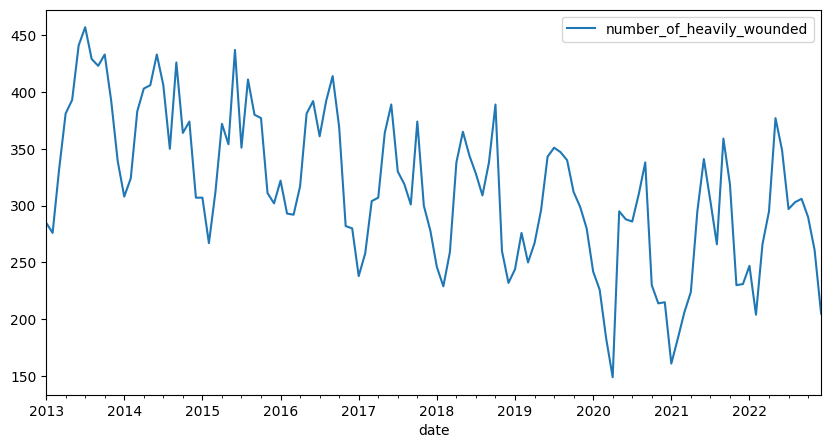

In [5]:
wounded_data.plot( y='number_of_heavily_wounded', figsize=[10,5]);

## Interludium

- What is the trend?
- What would you do to 'calculate' the exact trend?
- What is the seasonal component?
- Try to predict the number of heavily wounded for january 2023, based on the number of december 2022.
- Try to predict the number of heavily wounded for february 2023, based on the number of december 2022.
- Try to predict the number of heavily wounded for march 2023, based on the number of december 2022.


## Time series models

In the chart below, we attempt to model observed values with a constant function $X_t = b + \varepsilon_t$ (with $\varepsilon_t$ some random noise with constant variance). As an estimate for $b$, we take the average of the first observations. We can basically use our own judgement to choose how many.

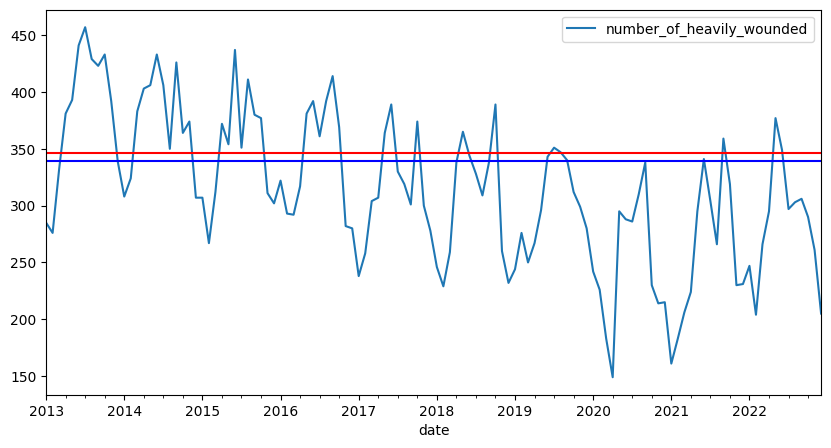

In [7]:
b_est_70 = wounded_data['number_of_heavily_wounded'].head(70).mean()
b_est_80 = wounded_data['number_of_heavily_wounded'].head(80).mean()

wounded_data.plot(y='number_of_heavily_wounded', figsize=[10,5]);
plt.axhline(y=b_est_70, color='red');   # Mean of first 70 observations
plt.axhline(y=b_est_80, color='blue')  # Mean of first 80 observations

If we want to model these values with a linear function $X_t = b_0 + b_1 t + \varepsilon_t$, we can use a technique we actually already used in another context: linear regression. A linear trend means that the time series variable changes by a constant amount each time
period.

The interpretation of $b_1$ is that it represents the expected change in the series from one
period to the next. If $b_1$ is positive, the trend is upward; if $b_1$ is negative, the trend is downward.
The intercept term $b_0$ is less important. It literally represents the expected value of the series at time t = 0.

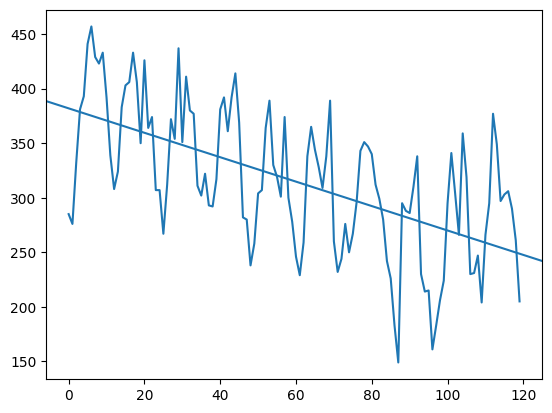

In [8]:
# Build a linear regression model
wounded_lm = LinearRegression().fit(
    np.arange(0,120).reshape((-1,1)),
    wounded_data['number_of_heavily_wounded'].values
)

# plot the time series and the regression line
plt.plot(np.arange(0,120), wounded_data['number_of_heavily_wounded']);
plt.axline((0, wounded_lm.intercept_), slope=wounded_lm.coef_[0]);

We can also use Seaborn's `regplot()` function to draw the regression line. We don't get the parameters, though...

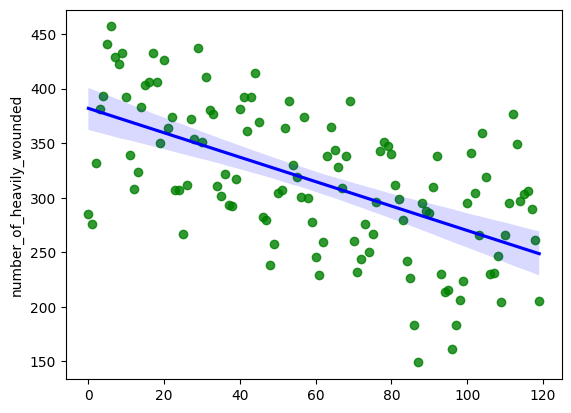

In [9]:

sns.regplot(
    x=np.arange(0,120),
    y=wounded_data['number_of_heavily_wounded'],
    line_kws={'color': 'b'},
    scatter_kws={'color':'g'});


This estimate doesn't seem useful. Maybe it's useful to adapt our model when new observations are added?

## Moving average

We basically need a method that takes the last observations into account, but forgets observations after some time. Older observations may no longer be representative of the current situation. Moving averages are such methods.

### Simple Moving Average

$$SMA(t) = \frac{1}{m} \sum_{i=k}^{t} x_i$$

With $m$ the time range (the number of observations taken into account) and $k$ = t - m + 1.

Suppose the data are monthly and you choose a time range of six months.
Then the prediction of the next month's value is the average of the values for the past six months. For example, you average January to June to forecast July, you average February to July to forecast August, and so on. This procedure is the reason for the term moving averages.
The role of the time range is important. If the span is large—say, 12 months—then many observations go into each average, and extreme values have relatively little effect on the forecasts. The resulting series of forecasts will be much smoother than the original series.  
In contrast, if the
span is small—say, three months—then extreme observations have a larger effect on the forecasts,
and the forecast series will be much less smooth.

The Pandas `Series` class has a method [`rolling()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.rolling.html) for "rolling window" calculations, which is perfectly suitable for what we want to do here.

We call the method `rolling(m)` with the desired time range and then calculate the `mean()`:

In [10]:
wounded_data['SMA3'] = wounded_data['number_of_heavily_wounded'].rolling(3).mean()
wounded_data['SMA5'] = wounded_data['number_of_heavily_wounded'].rolling(5).mean()
wounded_data['SMA10'] = wounded_data['number_of_heavily_wounded'].rolling(10).mean()
wounded_data

,number_of_heavily_wounded,SMA3,SMA5,SMA10
date,,,,
2013-01-01,285,NaN,NaN,NaN
2013-02-01,276,NaN,NaN,NaN
2013-03-01,332,297.666667,NaN,NaN
2013-04-01,381,329.666667,NaN,NaN
2013-05-01,393,368.666667,333.4,NaN
...,...,...,...,...
2022-08-01,303,316.333333,324.2,279.9
2022-09-01,306,302.000000,326.4,287.5
2022-10-01,290,299.666667,309.0,293.4


You'll notice that the first data points in the SMA columns are empty (`NaN`). At those time slots there are still not enough past observations to calculate the mean. The larger the time window, the more empty data points.

If you want to avoid empty cells, you can add the parameter `min_periods=1` to the method call of `rolling()`. In that case the mean will be calculated with any available past observation.

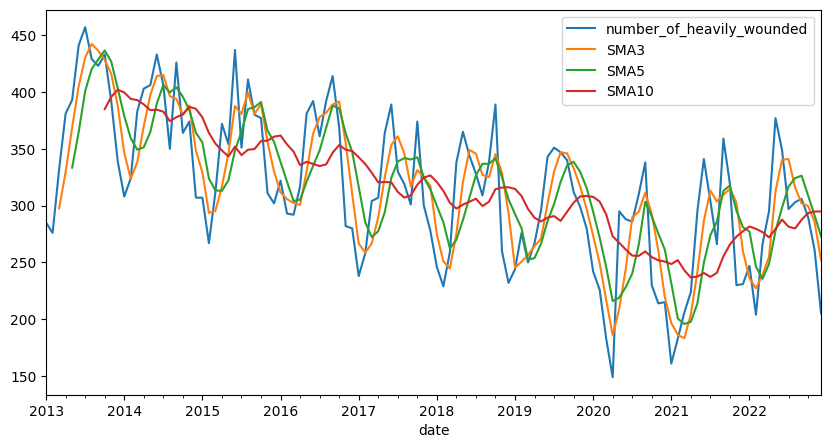

In [11]:
wounded_data.plot(
    y=['number_of_heavily_wounded', 'SMA3',	'SMA5',	'SMA10'],
    figsize=[10,5]);

As you will notice, SMA's with a short window will still follow fluctuations in the observations, while those with a longer window are more "stable", and resilient to short-term fluctuations.

There are two possible criticisms to the moving average method. First, it puts equal weight
on each value in a typical moving average. But one can argue that if the next month's
forecast should be based on the observations of the past 12 months, more weight should be
placed on the more recent observations. The second criticism is that the moving averages
method requires a lot of data storage.

**Exponential smoothing** is a method that addresses both points of criticism. It bases its
predictions on a weighted average of past observations, with more weight on the more recent
observations, and it requires very little data storage. Moreover, it is not difficult for most business people to understand, at least conceptually. Therefore, this method is widely used in the
business world, especially when frequent and automatic forecasts of many items are required.
There are many variations of exponential smoothing.
**Single exponential smoothing** is appropriate for a series with no pronounced trend or seasonality. **Holt's method** is appropriate for a series with trend but no seasonality.
**Winters' method** is appropriate for a series with seasonality (and possibly trend).

### Exponential Moving Average (EMA)

Also called *Single Exponential Smoothing* (SES).

$X_t = \alpha x_t + (1 - \alpha) X_{t-1}$

$F_{t+m} = X_t$

* $\alpha$ is the smoothing constant and is a number between 0 and 1
* $X_t$ is the _level_ of the series at time _t_. This value is not observable but can only be estimated. Essentially, it is
an estimate of where the series would be at time _t_ if there were no random noise.
* $F_{t+m}$ is the forecast at time m

The first equation shows how to update the estimate of the level.
It is a weighted average of the current observation, $x_t$ , and the previous level, $X_{t-1}$, with respective weights $\alpha$ and 1 − $\alpha$.   
The second equation shows how forecasts are made. It says
that the m-period-ahead forecast, $F_{t+m}$, made of $X_t$ in period $m$ is the most recently estimated level, $X_t$. This is the same for any value of m >= 1.
   The idea is that in simple exponential smoothing, you believe that the series is not really going anywhere. So as soon as you estimate where the series ought to be in period t (if it weren't for random noise), you use this as the forecast for any future period.

Pandas has a method [`ewm()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html) that can be used to calculate the exponential moving average.

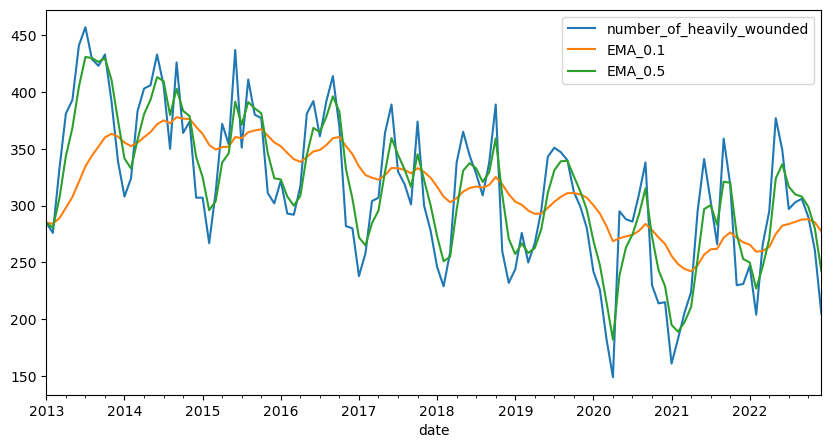

In [66]:
wounded_data['EMA_0.1'] = wounded_data['number_of_heavily_wounded'].ewm(alpha=.1, adjust=False).mean()
wounded_data['EMA_0.5'] = wounded_data['number_of_heavily_wounded'].ewm(alpha=.5, adjust=False).mean()

wounded_data.plot(y=['number_of_heavily_wounded',  'EMA_0.1', 'EMA_0.5'], figsize=[10,5]);

Play with the values of alpha. What is the effect if alpha is small (close to 0) or large (close to 1)?

A way to see the effect of α is to substitute recursively into the equation for $X_t$.  
By performing some algebra, you can verify that $X_t$ satifies the following equation, where sum extends back to the first observation at time = 1.

$X_t = \alpha x_{t} + \alpha (1 - \alpha) x_{t-1} + \alpha (1 - \alpha)^2 x_{t-2} + \alpha (1 - \alpha)^3 x_{t-3} + ...$

This equation shows how the exponentially smoothed forecast is a weighted average of previous observations. Furthermore, because 1 − $\alpha$ is less than 1, the weights on the x's decrease from time t backward.   
If $\alpha$ is close to 0, then 1 − $\alpha$ is close to 1 and the weights
decrease very slowly. In other words, observations from the distant past continue to have a large influence on the next forecast. This means that the graph of the forecasts will be relatively
smooth, just as with a large span in the moving averages method. But if $\alpha$ is close to 1, the weights decrease rapidly, and only very recent observations have much influence on
the next forecast. In this case forecasts react quickly to sudden changes in the series.

Unfortunately, the `ewm()` method does not allow us to do double or triple exponential smoothing. Statsmodels does have the necessary classes. For Single Exponential Smoothing, we can instantiate the [`SimpleExpSmoothing`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html#statsmodels.tsa.holtwinters.SimpleExpSmoothing) class and then call the [`fit()`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.fit.html#statsmodels.tsa.holtwinters.SimpleExpSmoothing.fit) method. The parameter $\alpha$ can be set with argument `smoothing_level`.

In [5]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Train the model
data_ses = SimpleExpSmoothing(wounded_data['number_of_heavily_wounded']).fit(
    smoothing_level=0.1, optimized=False)

# Add fitted values to the dataframe
wounded_data['SES'] = data_ses.level
wounded_data.head(20)

,number_of_heavily_wounded,SES
date,,
2013-01-01,285,285.000000
2013-02-01,276,284.100000
2013-03-01,332,288.890000
2013-04-01,381,298.101000
2013-05-01,393,307.590900
2013-06-01,441,320.931810
2013-07-01,457,334.538629
2013-08-01,429,343.984766
2013-09-01,423,351.886289


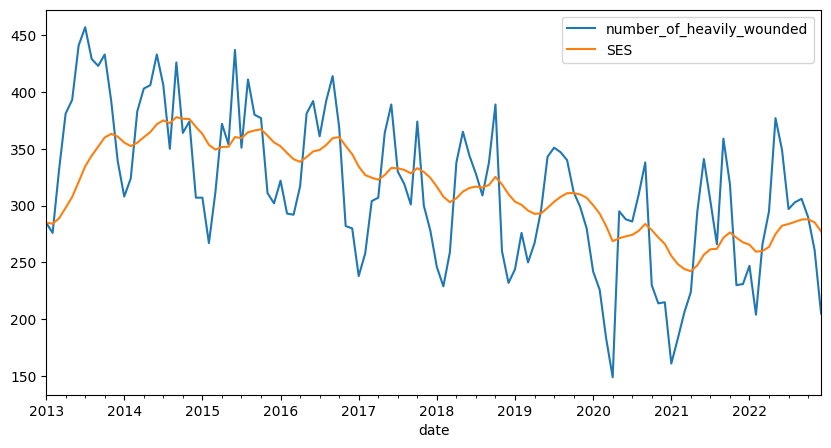

In [6]:
wounded_data.plot(y=['number_of_heavily_wounded',  'SES'], figsize=[10,5]);

These statsmodels classes allow us to do a prediction based on the model:

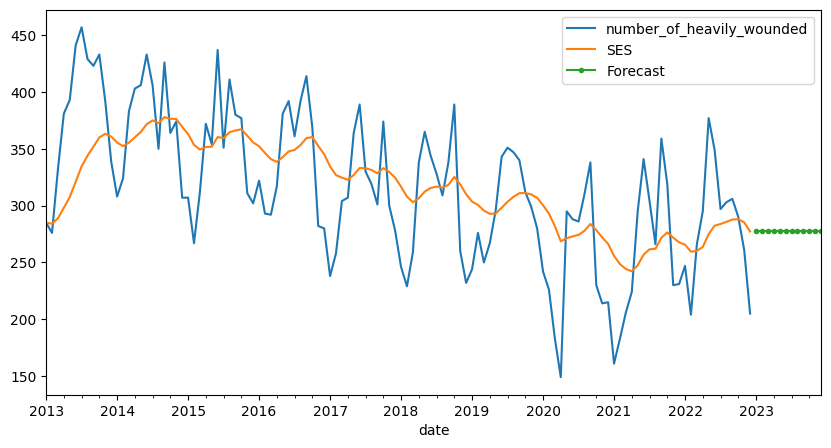

In [7]:
data_ses_fcast = data_ses.forecast(12)

wounded_data.plot(y=['number_of_heavily_wounded',  'SES'], figsize=[10,5])
data_ses_fcast.plot(marker='.', legend=True, label='Forecast');

If we look back at the formulae of Single Exponential Smoothing, the forecasted value for any value of m >= 1 is the _level_ of the series at time _t_:

$X_t = \alpha x_t + (1 - \alpha) X_{t-1}$

$F_{t+m} = X_t$

If we take a look at the plot, this looks correct, but let's check if this is actually the case using the data coming out of the model.  
First we retrieve the level's $X_t$ of the model

In [70]:
data_ses.level

date
2013-01-01    285.000000
2013-02-01    284.100000
2013-03-01    288.890000
2013-04-01    298.101000
2013-05-01    307.590900
                 ...    
2022-08-01    285.743838
2022-09-01    287.769454
2022-10-01    287.992509
2022-11-01    285.293258
2022-12-01    277.263932
Freq: MS, Length: 120, dtype: float64

Now we print out the forecasted values:

In [71]:
data_ses_fcast.values

array([277.26393201, 277.26393201, 277.26393201, 277.26393201,
       277.26393201, 277.26393201, 277.26393201, 277.26393201,
       277.26393201, 277.26393201, 277.26393201, 277.26393201])

We can see that the last value of data_ses.level is indeed the same as all the forecasted values for m >= 1.

When we use Single Exponential Smoothing, we assume that the underlying time series fluctutates around some constant value. This is what is reflected by the forecasted values (in green), which are always the same.

Sometimes we want to compare the actual, observed value to the value that was predicted by the model. In the previous example, we saw that the value  $X_t$  at time $t$ is the model's prediction for the actual value at time $t + 1$.
So, to calculate the difference between the actual, observed value (at time $t + 1$) and the predicted value (at time $t$), we would need to shift the column data['SES'] one down and make the difference between the columns data['number_of_heavily_wounded'] and data['SES']. This seems quite a burden. Luckily .fittedvalues is there to come to the rescue: it contains the value predicted by the model at time $t$.

In [10]:
wounded_data['SES_predicted_value'] = data_ses.fittedvalues
wounded_data.tail()

,number_of_heavily_wounded,SES,SES_predicted_value
date,,,
2022-08-01,303,285.743838,283.826486
2022-09-01,306,287.769454,285.743838
2022-10-01,290,287.992509,287.769454
2022-11-01,261,285.293258,287.992509
2022-12-01,205,277.263932,285.293258


Finally we can also retrieve the automatically calculated parameters of the model: use .params_formatted to obtain a dataframe containing all parameters:

In [73]:
data_ses.params_formatted

,name,param,optimized
smoothing_level,alpha,0.1,False
initial_level,l.0,285.0,False


### Double exponential smoothing

The single exponential smoothing model generally works well if there is no obvious trend in the series. But if there is a trend, this method consistently lags behind it. For example, if the series is constantly increasing, single exponential smoothing forecasts will be consistently
low. Holt's method rectifies this by dealing with trend explicitly. In addition to
the level of the series, $X_{t}$, Holt's method includes a trend term, $b_{t}$ , and a corresponding
smoothing constant $\beta$. The interpretation of $X_{t}$ is exactly as before. The interpretation of $b_{t}$ is that it represents an estimate of the change in the series from one period to the next.

So, if we suspect that there is a long-term (increasing or decreasing) trend in the time series, we can use Holt's Method or also called Double Exponential Smoothing (DES).

$X_{t} = \alpha x_{t} + (1-\alpha)(X_{t-1} + b_{t-1})$

$b_{t} = \beta(X_{t}-X_{t-1}) + (1-\beta)b_{t-1}$

$F_{t+m} = X_t + mb_t$

with smoothing parameters $0 < \alpha < 1$ and $0 < \beta < 1$. $b_t$ is an estimate for the trend at time $t$ and can also be interpreted as the slope of a regression line.

The first equation says that the updated level is a weighted average of the current observation and the previous level plus the estimated change.  
The second equation says that the updated trend is a weighted average of the difference between two consecutive levels and the previous trend.  
The third equation says that the $m$-period-ahead forecast made in period t is the estimated level plus m times the estimated change per period.

Everything that was said about $\alpha$ for single exponential smoothing applies to both $\alpha$ and $\beta$ in Holt's model. The new smoothing constant $\beta$ controls how quickly the method reacts to observed changes in the trend. If $\beta$ is small, the method reacts slowly. If it is large, the method reacts more quickly.

In Python, you can instantiate the class [`Holt`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.Holt.html#statsmodels.tsa.holtwinters.Holt) and call the [`fit()`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.Holt.fit.html#statsmodels.tsa.holtwinters.Holt.fit) method. The smoothing parameters $\alpha$ and $\beta$ can be set with arguments `smoothing_level` and `smoothing_trend`, respectively. If you don't specify these, suitable values will be calculated using some rule of thumb.

In [74]:
from statsmodels.tsa.api import Holt

data_des = Holt(wounded_data['number_of_heavily_wounded']).fit(
    smoothing_level=.1,
    smoothing_trend=.2,
    optimized=False)

wounded_data['DES'] = data_des.level
wounded_data.tail()


,number_of_heavily_wounded,SMA3,SMA5,SMA10,EMA_0.1,EMA_0.5,SES,SES_predicted_value,DES
date,,,,,,,,,
2022-08-01,303,316.333333,324.2,279.9,285.743838,309.859432,285.743838,283.826486,302.285306
2022-09-01,306,302.000000,326.4,287.5,287.769454,307.929716,287.769454,285.743838,308.133299
2022-10-01,290,299.666667,309.0,293.4,287.992509,298.964858,287.992509,287.769454,311.753826
2022-11-01,261,285.666667,291.4,294.8,285.293258,279.982429,285.293258,287.992509,311.677225
2022-12-01,205,252.000000,273.0,294.9,277.263932,242.491215,277.263932,285.293258,304.994739


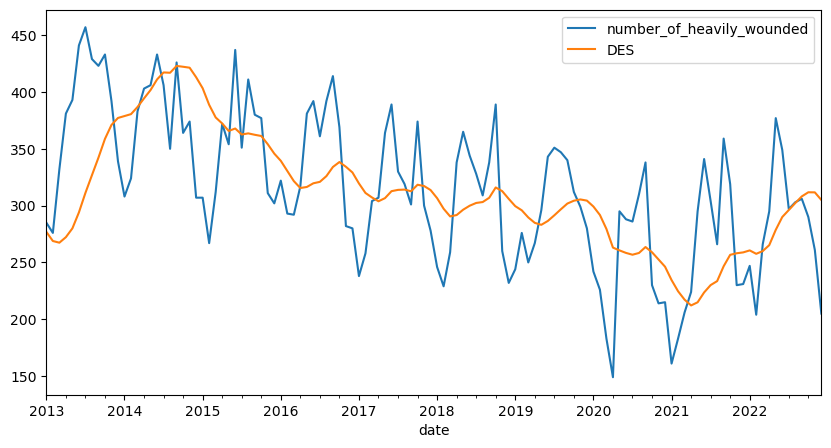

In [75]:
wounded_data.plot(y=['number_of_heavily_wounded',  'DES'], figsize=[10,5]);

We can retrieve the parameters of the model (smoothing parameters, initial estimate of constant term and trend):

In [76]:
data_des.params_formatted

,name,param,optimized
smoothing_level,alpha,0.1,False
smoothing_trend,beta,0.2,False
initial_level,l.0,285.0,False
initial_trend,b.0,-9.0,False


To use this model for forecasting:

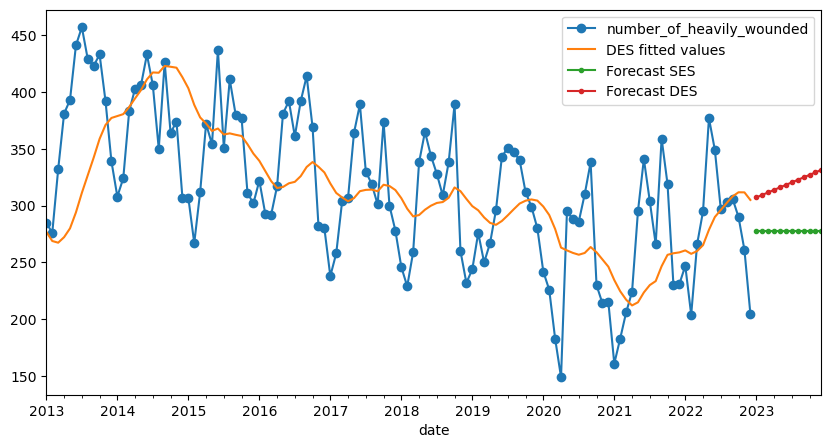

In [77]:
data_des_fcast = data_des.forecast(12)

# Plot observations, fitted values and forecast
wounded_data['number_of_heavily_wounded'].plot(marker='o', legend=True)
wounded_data['DES'].plot(legend=True, label='DES fitted values', figsize=[10,5]);
data_ses_fcast.plot(marker='.', legend=True, label='Forecast SES');
data_des_fcast.plot(marker='.', legend=True, label='Forecast DES');

As we can see, the predictions are now increasing:


In [78]:
data_des_fcast

2023-01-01    307.200674
2023-02-01    309.406609
2023-03-01    311.612544
2023-04-01    313.818479
2023-05-01    316.024415
2023-06-01    318.230350
2023-07-01    320.436285
2023-08-01    322.642220
2023-09-01    324.848155
2023-10-01    327.054091
2023-11-01    329.260026
2023-12-01    331.465961
Freq: MS, dtype: float64

The formula for predicting values, was:

$F_{t+m} = X_t + mb_t$

Take a look at the values of the level's $X_t$ and the trend $b_t$, to  understand the predicted values, as are printed here before.
*   Explain the forecasted value of 2023-01-01
*   Explain the forecasted value of 2023-02-01
*   ...



In [79]:
data_des.level

date
2013-01-01    276.900000
2013-02-01    268.872000
2013-03-01    267.389360
2013-04-01    272.247197
2013-05-01    279.994306
                 ...    
2022-08-01    302.285306
2022-09-01    308.133299
2022-10-01    311.753826
2022-11-01    311.677225
2022-12-01    304.994739
Freq: MS, Length: 120, dtype: float64

In [80]:
data_des.trend

date
2013-01-01   -8.820000
2013-02-01   -8.661600
2013-03-01   -7.225808
2013-04-01   -4.809079
2013-05-01   -2.297841
                ...   
2022-08-01    6.085026
2022-09-01    6.037619
2022-10-01    5.554201
2022-11-01    4.428040
2022-12-01    2.205935
Freq: MS, Length: 120, dtype: float64

Again, we can use .fittedvalues to compare the predicted value at time $t$ to the actual, observed value at time $t$.

In [81]:
wounded_data['DES_prediction_next_month'] = data_des.level + data_des.trend # predicted value for next month => m = 1
wounded_data['DES_fittedvalues'] = data_des.fittedvalues
wounded_data.tail()

,number_of_heavily_wounded,SMA3,SMA5,SMA10,EMA_0.1,EMA_0.5,SES,SES_predicted_value,DES,DES_prediction_next_month,DES_fittedvalues
date,,,,,,,,,,,
2022-08-01,303,316.333333,324.2,279.9,285.743838,309.859432,285.743838,283.826486,302.285306,308.370332,302.205896
2022-09-01,306,302.000000,326.4,287.5,287.769454,307.929716,287.769454,285.743838,308.133299,314.170918,308.370332
2022-10-01,290,299.666667,309.0,293.4,287.992509,298.964858,287.992509,287.769454,311.753826,317.308028,314.170918
2022-11-01,261,285.666667,291.4,294.8,285.293258,279.982429,285.293258,287.992509,311.677225,316.105265,317.308028
2022-12-01,205,252.000000,273.0,294.9,277.263932,242.491215,277.263932,285.293258,304.994739,307.200674,316.105265


### Triple Exponential Smoothing

As mentioned in the introduction, seasonality is the consistent
month-to-month (or quarter-to-quarter) differences that occur each year. (It could also be the day-to-day differences that occur each week.) For example, there is seasonality toy sales, with
a huge peak in the months preceding Christmas.

How can you tell whether there is seasonality in a time series? The easiest way is to check whether a graph of the time series has a regular pattern of ups and/or downs in particular months or quarters.

In an **additive seasonal model**, an appropriate seasonal index is added to a base
forecast.

In a **multiplicative seasonal model**, a base forecast is multiplied by an appropriate
seasonal index.

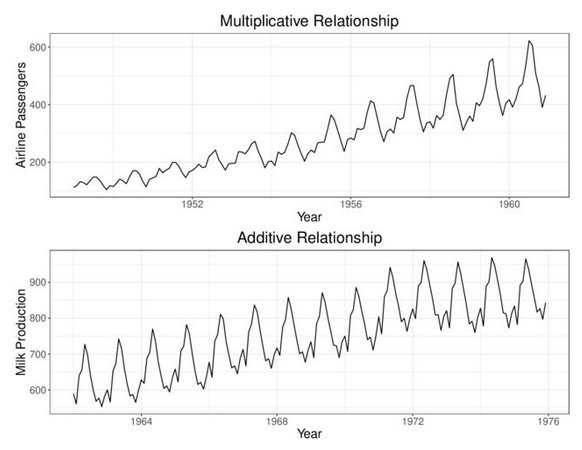

To deal with seasonality, one can use (a.o.) Holt-Winters' exponential smoothing model. It is very similar to Holt's model—
it again has level and trend terms and corresponding smoothing constants $\alpha$ and $\beta$ —but it also has seasonal indexes and a corresponding smoothing constant $\gamma$ (gamma). This new
smoothing constant controls how quickly the method reacts to observed changes in the seasonality pattern. If $\gamma$ is small, the method reacts slowly. If it is large, the method reacts more
quickly. As with Holt's model, there are equations for updating the level and trend terms, and there is one extra equation for updating the seasonal indexes.

Triple Exponential Smoothing (TES), also called *Holt-Winter's Method*, can in addition also model seasonally recurring trends.

- Level smoothing: $X_{t} = \alpha \frac{x_{t}}{c_{t-L}} + (1-\alpha) (X_{t-1} + b_{t-1})$
- Trend smoothing: $b_{t} = \beta (X_{t} - X_{t-1}) + (1-\beta)b_{t-1}$
- Seasonal smoothing: $c_{t} = \gamma \frac{x_{t}}{X_{t}} + (1-\gamma)c_{t-L}$
- Forecast for $m$ time units after the last observation: $F_{t+m} = (X_{t} + m b_{t})c_{t-L+1+(m-1) \mod L}$

In these formulas, the following additional notation is used:

- $L$ is the length (in number of time units) of the seasonal cycle. Common values are 7 for a weekly cycle, 4 for a quarterly one, 12 for a monthly cycle, etc.
- $0 < \gamma < 1$ is the smoothing parameter for the seasonal trend (like $\alpha$ and $\beta$). Set this value in the `fit()` method using argument `smoothing_seasonal`.
- $c_t$ are estimates for the seasonal correction factors, one for each time unit $t\mod L$ within the seasonal cycle.

To understand how the forecast equation works, suppose you have observed data through June and you want a forecast for the coming September, that is, a three-month-ahead forecast. (In this case t refers to June and t + m = t + 3 refers to September.) The method first adds 3 times the current trend term to the current level. This gives a forecast
for September that would be appropriate if there were no seasonality. Next, it adds this forecast by the most recent estimate of September's seasonal index (the one from the
previous September) to get the forecast for September.

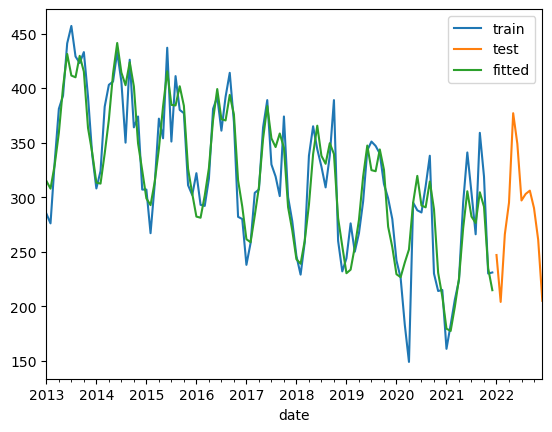

In [82]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train = wounded_data.number_of_heavily_wounded[:-12]
test = wounded_data.number_of_heavily_wounded[-12:]

wounded_hw = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12, freq='MS').fit()

train.plot(legend=True, label='train')
test.plot(legend=True, label='test')
(wounded_hw.level + wounded_hw.season).plot(legend=True, label='fitted');

Let's use the model to make a forecast.
Applied to the number of heavily wounded, we calculate a forecast for the last year (i.e. the test data) as follows:

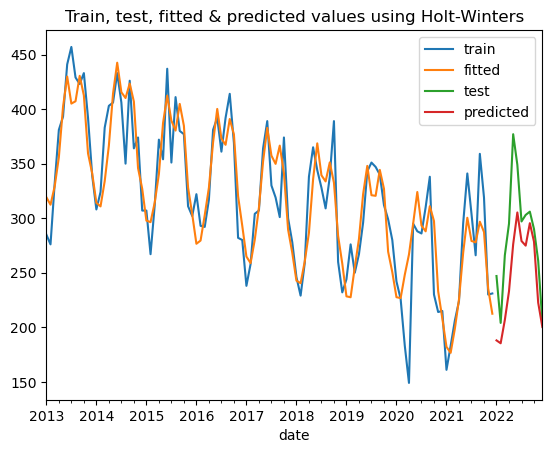

In [83]:
wounded_predicted = wounded_hw.forecast(12)

train.plot(legend=True, label='train')
wounded_hw.fittedvalues.plot(legend=True, label='fitted')

test.plot(legend=True, label='test')
wounded_predicted.plot(legend=True, label='predicted')

plt.title('Train, test, fitted & predicted values using Holt-Winters');


Let's zoom in on the forecasted period to compare test data and predictions:

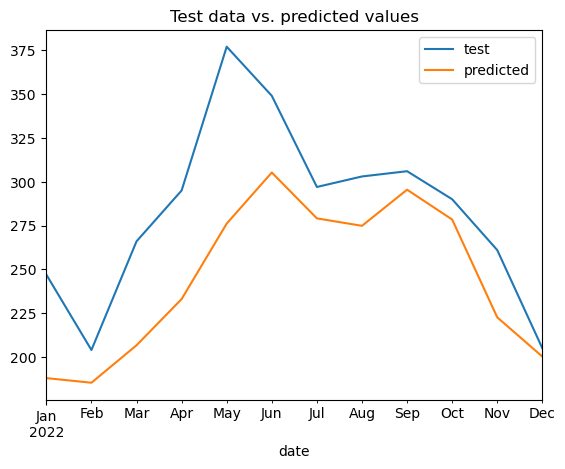

In [84]:
test.plot(legend=True, label='test');
wounded_predicted.plot(legend=True, label='predicted');
plt.title('Test data vs. predicted values');

In [85]:
wounded_predicted

2022-01-01    187.986439
2022-02-01    185.351494
2022-03-01    206.708105
2022-04-01    233.072289
2022-05-01    276.132494
2022-06-01    305.248726
2022-07-01    279.096507
2022-08-01    274.844103
2022-09-01    295.462496
2022-10-01    278.427250
2022-11-01    222.638073
2022-12-01    200.258976
Freq: MS, dtype: float64

Again, we can retrieve the internals of the model. These are the relevant attributes:

- `level` contains all level estimates ($X_i$) for each time unit in the training data
- `trend` contains all trend estimates ($b_i$)
- `season` contains all estimates for the seasonal adjustment factors. ($c_i$)
- `params` (dict output) or `params_formatted` (table output) contains all parameters used to bootstrap the model (including automatically calculated ones).

In [86]:
# Retrieve the automatically calculated parameters of the model:
wounded_hw.params_formatted

,name,param,optimized
smoothing_level,alpha,0.122687,True
smoothing_trend,beta,0.009324,True
smoothing_seasonal,gamma,0.001778,True
initial_level,l.0,384.940128,True
initial_trend,b.0,-1.203172,True
initial_seasons.0,s.0,-64.495486,True
initial_seasons.1,s.1,-65.931719,True
initial_seasons.2,s.2,-43.362649,True
initial_seasons.3,s.3,-15.793236,True
initial_seasons.4,s.4,28.461948,True


Forecasting is done using the final values for the level, trend and seasonal adjustment factor estimates. Let's retrieve them from the model:

In [87]:
wounded_hw.level

date
2013-01-01    379.535967
2013-02-01    373.832485
2013-03-01    372.893802
2013-04-01    374.702365
2013-05-01    372.357014
                 ...    
2021-08-01    245.600070
2021-09-01    251.907301
2021-10-01    254.531244
2021-11-01    252.634588
2021-12-01    253.686847
Freq: MS, Length: 108, dtype: float64

In [88]:
wounded_hw.trend

date
2013-01-01   -1.242342
2013-02-01   -1.283938
2013-03-01   -1.280719
2013-04-01   -1.251914
2013-05-01   -1.262109
                ...   
2021-08-01   -1.326642
2021-09-01   -1.255464
2021-10-01   -1.219292
2021-11-01   -1.225608
2021-12-01   -1.204369
Freq: MS, Length: 108, dtype: float64

In [89]:
wounded_hw.season

date
2013-01-01   -64.556384
2013-02-01   -65.996388
2013-03-01   -43.357644
2013-04-01   -15.748454
2013-05-01    28.446097
                ...    
2021-08-01    30.792209
2021-09-01    52.614972
2021-10-01    36.784094
2021-11-01   -17.800713
2021-12-01   -38.942421
Freq: MS, Length: 108, dtype: float64

The model performs forecasts by:

- Taking the last level estimate
- Taking the last trend estimate
- Taking the last estimate for the appropriate seasonal adjustment factor
- Computing the forecast formula given above

Let's verify this for the first forecasted value, for 2022-01-01:

In [96]:
# Predicted value by forecast():
print(wounded_predicted.iloc[0])

# Computed manually from model internals:
(wounded_hw.level.iloc[-1] + wounded_hw.trend.iloc[-1]) + wounded_hw.season.iloc[-12]

187.98643922124091


187.98643922124091

How would you calculate the forecast for 2022-02-01? And 2022-03-01?  

### Evaluating the quality of a model

In the Holt-Winters model, there are 3 smoothing constants: $\alpha$, $\beta$ and $\gamma$. What are the most appropriate values? Should $\alpha$ be 0.1, or rather 0.5? And what about $\beta$?
We need a metric to help us decide if one model performs better than another model.

Two commonly used metrics for this are the Mean Absolute Error (MAE) and Mean Squared Error (MSE), in which we compare the $m$ forecasted values with the observed values in the test set.

$$MAE = \frac{1}{m} \sum_{i=t+1}^{t+m} \left| x_i - F_i \right|$$

$$MSE = \frac{1}{m} \sum_{i=t+1}^{t+m} (x_i - F_i)^{2}$$

Remark the similarities between the formula for MSE and variance!

Applied to our case, we get:

In [91]:
wounded_predicted

2022-01-01    187.986439
2022-02-01    185.351494
2022-03-01    206.708105
2022-04-01    233.072289
2022-05-01    276.132494
2022-06-01    305.248726
2022-07-01    279.096507
2022-08-01    274.844103
2022-09-01    295.462496
2022-10-01    278.427250
2022-11-01    222.638073
2022-12-01    200.258976
Freq: MS, dtype: float64

In [92]:
test

date
2022-01-01    247
2022-02-01    204
2022-03-01    266
2022-04-01    295
2022-05-01    377
2022-06-01    349
2022-07-01    297
2022-08-01    303
2022-09-01    306
2022-10-01    290
2022-11-01    261
2022-12-01    205
Freq: MS, Name: number_of_heavily_wounded, dtype: int64

In [93]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

print(f'MAE = {mean_absolute_error(test,wounded_predicted)}')
print(f'MSE = {mean_squared_error(test,wounded_predicted)}')

MAE = 37.897753969287784
MSE = 2176.811417767226


In order to evaluate whether our model performs well, we can compare MSE with the variance in the data, or the square root of the MSE with the standard deviation:

In [97]:
print(f'√MSE  = {np.sqrt(mean_squared_error(test,wounded_predicted))}')
print(f'stdev = {wounded_data.number_of_heavily_wounded.std()}')

√MSE  = 46.65631166055913
stdev = 66.03568341884434


The square root of the MSE is well within one standard deviation of the original data, which is an indicator that the model performs well.

A data scientist could try to tweak the parameters (like $\alpha$, $\beta$ and $\gamma$, but also initial values of the estimators like $X_t$, $b_t$ and $c_t$) of the model to attain an even lower MSE. When we are satisfied with the model's performance, we can start using it "in production". We could retrain the model with these parameters on the entire dataset and make forecasts for time units.

### Decomposing a time series

A data series that shows a long term and seasonal trend can be "decomposed":

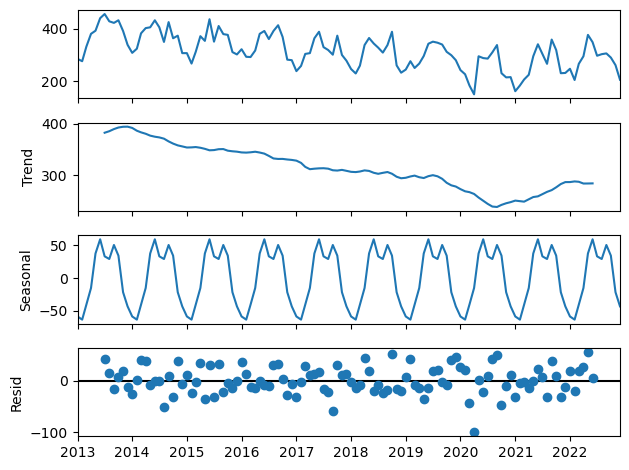

In [98]:
from statsmodels.tsa.seasonal import seasonal_decompose

# remove other columns (e.g. SES, DES, ...)
data = wounded_data[['number_of_heavily_wounded']]

wounded_decomposed = seasonal_decompose(data, model='additive')
wounded_decomposed.plot();

- The top graph shows the observations
- The second graph is the long term trend (which seems to be linear, so the choice for an additive model was appropriate)
- The third graph shows the seasonal trend
- The final graph are the residues

The semicolon at the end of line 4 is not strictly necessary, but if you leave it out, it's possible that the plot is shown twice.




## Sources

Khan, E. (2021-01-05) *Python Code on Holt-Winters Forecasting.* Retrieved 2022-04-15 from <https://medium.com/analytics-vidhya/python-code-on-holt-winters-forecasting-3843808a9873>

Moreno, A.I. (2020-07-08) *Moving Averages with Python: Simple, cumulative and exponential moving averages with Pandas*, retrieved 2022-04-15 from <https://towardsdatascience.com/moving-averages-in-python-16170e20f6c>

Paramita (2020-12-17) *Holt winters Model, Easiest Times series Model. Additive multiplicative trend and seasonality*, retrieved 2022-04-16 from <https://www.youtube.com/watch?v=O6cUkdQeLUQ>

Perktold, J., et al. (2022-04-13) *statsmodels manual: Exponential Smoothing.* Retrieved 2022-04-15 from <https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html>